In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from methods import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Loads files as dataframes
data_ent_followup = create_df("f_Sections F,G,h - Ent.dta", "Analysis files/data/Followup/{0}")

data_edu_baseline = create_df("education.dta", "Analysis files/data/Baseline/{0}")

data_ent_baseline = create_df("Sections F,G,h - Ent.dta", "Analysis files/data/Baseline/{0}")

data_age_baseline = create_df("personal info.dta", "Analysis files/data/Baseline/{0}")

In [3]:
#Removes attrition from the baseline dataframes
updated_edu_baseline = remove_attrition(data_edu_baseline, data_ent_followup)
updated_ent_baseline = remove_attrition(data_ent_baseline, data_ent_followup)
updated_age_baseline = remove_attrition(data_age_baseline, data_ent_followup)

Number of households at followup:  961
Number of households at adjusted baseline:  961
Number of households at followup:  961
Number of households at adjusted baseline:  961
Number of households at followup:  961
Number of households at adjusted baseline:  961


In [4]:
#Creates big array with the desired columns of edu_baseline, ent_baseline, and ent_followup.
#Contains the columns specified below.
#Corrects NaN values to zero.
ent_edu_master = updated_ent_baseline[['treatment_x', 'rescode', 'enterprise', 'soleent']].join(data_ent_followup[['f_enterprise', 'f_soleent']])
ent_edu_master = ent_edu_master.join(updated_edu_baseline[["edulow", "eduvoc", "eduhigh"]])
ent_edu_master = ent_edu_master.join(updated_age_baseline[["age"]])
ent_edu_master = ent_edu_master.fillna(0)

In [5]:
#Find number of participants in each age bin: 18-39, 40-69
ent_edu_age2 = ent_edu_master.copy()

ent_edu_age2['age'] = ent_edu_age2['age'].apply(lambda x: x//10)
ent_edu_age2.loc[ent_edu_age2.age==1, 'age'] = 3
ent_edu_age2.loc[ent_edu_age2.age==6, 'age'] = 4
ent_edu_age2.loc[ent_edu_age2.age==2, 'age'] = 3
ent_edu_age2.loc[ent_edu_age2.age==5, 'age'] = 4

for i in range(10):
    print(i,')', len(ent_edu_age2.loc[(ent_edu_age2['age'] == i)&(ent_edu_age2['treatment_x']==2), :]))
    
ageBins = ['18-39', '40-69']

for i in range(3, 5):
    ent_edu_age2.loc[ent_edu_age2['age']==i, 'agebin'] = ageBins[i-3]

0 ) 0
1 ) 0
2 ) 0
3 ) 169
4 ) 182
5 ) 0
6 ) 0
7 ) 0
8 ) 0
9 ) 0


In [6]:
#control: treatment_x = 0
#individual: treatment_x = 1
#group: treatment_x = 2

In [7]:
def mean(column):
    sum = column.sum()
    length = len(column)
    return sum/length

def sd(column):
    sum = 0
    m = mean(column)
    for i in range(len(column)):
        sum = sum + math.pow(column.iloc[i] - m, 2)
    return math.pow(sum/len(column), 0.5)

def ci_ND(column):
    sd_ = sd(column)
    return (1.96*sd_)/math.pow(len(column), 0.5)

In [8]:
ent_edu_age2['difference'] = ent_edu_age2['f_soleent'] - ent_edu_age2['soleent']

In [9]:
#Copy of ent_edu_master for 'conversion rate' analysis, adds edu column, 
ent_edu_age2['edu'] = ent_edu_age2['edulow']*2 + ent_edu_age2['eduvoc']*2 + ent_edu_age2['eduhigh'] * 3
eduBins = ['edulow & voc ', 'eduhigh']
for i in range(2, 4):
    ent_edu_age2.loc[ent_edu_age2['edu']==i, 'edubin'] = eduBins[i-2]



In [10]:
#ent_edu_age2
treatment = 1

In [11]:
#avg. change chart with binning by age AND edu for GROUP or INDIVIDUAL
eduANDageGroup = pd.DataFrame(columns = ['edu', 'edubin', 'agebin', 'avg. change', 'sd', 'margin of error', 'all people']) 

for i in range(3, 5):
    for j in range(2, 4):
        ap = len(ent_edu_age2[(ent_edu_age2.treatment_x == treatment)&(ent_edu_age2.age == i) & (ent_edu_age2.edu == j)])
        diff = ent_edu_age2[(ent_edu_age2.treatment_x == treatment)&(ent_edu_age2.age == i) & (ent_edu_age2.edu == j)].difference.sum()
        agebin = ent_edu_age2[(ent_edu_age2['age'] == i)].iloc[0]['agebin']
        edubin = ent_edu_age2[(ent_edu_age2['edu'] == j)].iloc[0]['edubin']
        if ap != 0:
            sd_ = sd(ent_edu_age2[(ent_edu_age2.treatment_x == treatment)&(ent_edu_age2.age == i) & (ent_edu_age2.edu == j)].difference)
            mOe = ci_ND(ent_edu_age2[(ent_edu_age2.treatment_x == treatment)&(ent_edu_age2.age == i) & (ent_edu_age2.edu == j)].difference)
            eduANDageGroup = eduANDageGroup.append({'edu': j, 'edubin': edubin, 'agebin': agebin, 'avg. change': diff/ap, 'sd' : sd_, 'margin of error': mOe, 'all people' : ap}, ignore_index=True)
        else:
            eduANDageGroup = eduANDageGroup.append({'edu': j, 'edubin': edubin, 'agebin': agebin, 'avg. change': 0, 'sd' : 0, 'margin of error': 0, 'all people' : 0}, ignore_index=True)

eduANDageGroup

,edu,edubin,agebin,avg. change,sd,margin of error,all people
0,2,edulow & voc,18-39,-0.148936,0.544947,0.155798,47
1,3,eduhigh,18-39,-0.031746,0.533579,0.093169,126
2,2,edulow & voc,40-69,0.030303,0.549647,0.132608,66
3,3,eduhigh,40-69,-0.009009,0.511058,0.095075,111


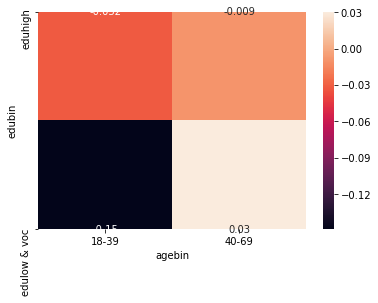

In [12]:
eduANDageGroupGraphing = eduANDageGroup.pivot("edubin", "agebin", "avg. change")
ax = sns.heatmap(eduANDageGroupGraphing, annot=True)

In [13]:
#avg. change chart with binning by age AND edu for CONTROL
eduANDageGroupControlled = pd.DataFrame(columns = ['edu', 'edubin', 'agebin', 'avg. change', 'sd', 'margin of error', 'all people']) 

for i in range(3, 5):
    for j in range(2, 4):
        ap = len(ent_edu_age2[(ent_edu_age2.treatment_x == 0)&(ent_edu_age2.age == i) & (ent_edu_age2.edu == j)])
        diff = ent_edu_age2[(ent_edu_age2.treatment_x == 0)&(ent_edu_age2.age == i) & (ent_edu_age2.edu == j)].difference.sum()
        agebin = ent_edu_age2[(ent_edu_age2['age'] == i)].iloc[0]['agebin']
        edubin = ent_edu_age2[(ent_edu_age2['edu'] == j)].iloc[0]['edubin']
        if ap != 0:
            sd_ = sd(ent_edu_age2[(ent_edu_age2.treatment_x == 0)&(ent_edu_age2.age == i) & (ent_edu_age2.edu == j)].difference)
            mOe = ci_ND(ent_edu_age2[(ent_edu_age2.treatment_x == 0)&(ent_edu_age2.age == i) & (ent_edu_age2.edu == j)].difference)
            eduANDageGroupControlled = eduANDageGroupControlled.append({'edu': j, 'edubin': edubin, 'agebin': agebin, 'avg. change': diff/ap, 'sd' : sd_, 'margin of error':mOe, 'all people' : ap}, ignore_index=True)
        else:
            eduANDageGroupControlled = eduANDageGroupControlled.append({'edu': j, 'edubin': edubin, 'agebin': agebin, 'avg. change': 0, 'sd' : 0, 'margin of error':0, 'all people' : 0}, ignore_index=True)

eduANDageGroupControlled

,edu,edubin,agebin,avg. change,sd,margin of error,all people
0,2,edulow & voc,18-39,0.032258,0.594809,0.209389,31
1,3,eduhigh,18-39,0.076087,0.629591,0.128653,92
2,2,edulow & voc,40-69,-0.015625,0.544638,0.133436,64
3,3,eduhigh,40-69,-0.109589,0.511823,0.117413,73


In [14]:
#avg. change chart with binning by age AND edu for GROUP or INDIVIDUAL - CONTROL
eduANDageGroupSubtracted = pd.DataFrame(columns = ['edu', 'edubin', 'agebin', 'avg. change', 'margin of error', 'all people T', 'all people C']) 
for i in range(4):
    education = eduANDageGroup.edu.iloc[i]
    educationBin = eduANDageGroup.edubin.iloc[i]
    ageBin = eduANDageGroup.agebin.iloc[i]
    diff = eduANDageGroup['avg. change'].iloc[i] - eduANDageGroupControlled['avg. change'].iloc[i]
    sdT = eduANDageGroup.sd.iloc[i]
    nT = eduANDageGroup['all people'].iloc[i]
    sdC = eduANDageGroupControlled.sd.iloc[i]
    nC = eduANDageGroupControlled['all people'].iloc[i]
    varSum = math.pow(sdT, 2)/nT + math.pow(sdC, 2)/nC
    err = 1.96 * math.pow(varSum, 0.5)
    eduANDageGroupSubtracted = eduANDageGroupSubtracted.append({'edu':education, 'edubin':educationBin, 'agebin':ageBin, 'avg. change':diff, 'margin of error':err, 'all people T':nT, 'all people C':nC}, ignore_index=True)
eduANDageGroupSubtracted

,edu,edubin,agebin,avg. change,margin of error,all people T,all people C
0,2,edulow & voc,18-39,-0.181194,0.260991,47,31
1,3,eduhigh,18-39,-0.107833,0.158846,126,92
2,2,edulow & voc,40-69,0.045928,0.188122,66,64
3,3,eduhigh,40-69,0.100580,0.151079,111,73


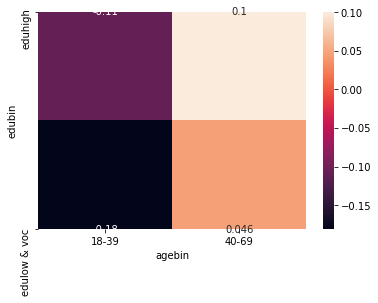

In [15]:
eduANDageGroupSubtractedGraphing = eduANDageGroupSubtracted.pivot("edubin", "agebin", "avg. change")
ax = sns.heatmap(eduANDageGroupSubtractedGraphing, annot=True)